# Portfolio analysis and rebalancing tool
*by Magdalena Gawron*

In [1]:
# Install some packages

from IPython.display import clear_output
!pip install yfinance
!pip install yahoofinancials
!pip install mypy-ipython

# Clear the output
clear_output()

In [2]:
# Imports
from typing import Mapping, Optional, List, Tuple
import pandas as pd
import numpy as np
import math
import random
import copy
import urllib.request
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext mypy_ipython

# Clear the output
from IPython.display import clear_output
clear_output()

pd.options.display.float_format = "{:,.1f}".format

print("Done")

Done


## Portfolio class
Run this cell to set up the portfolio class.
No input is needed.

In [25]:
%mypy
def _generate_colors(items_list: List[str]) -> List[Tuple[float, float, float, float]]:
    """Method generating colors of same shade across each category of assets."""
    
    i_prev = items_list[0]
    counts = [1]
    for j in items_list[1:]:
        if j == i_prev:
            counts[-1] += 1
        else:
            counts.append(1)
        i_prev = j
    output = []
    sample_colors = [(225/255, 112/255, 85/255), (9/255, 132/255, 227/255),
                     (214/255, 48/255, 49/255), (6/255, 82/255, 221/255)]
    
    for ind, c in enumerate(counts):
        if ind < len(sample_colors):
            rgb = sample_colors[ind]
        else:
            rgb = (0.2, 0.0, 1/(ind+1))
        for i in range(c):
            output.append(rgb + (1/(i+1.4),))
    return output


class NoAssetsAvailable(Exception):
    pass

# Define Portfolio class


class Portfolio():
    def __init__(self, currency: str):
        self.default_cur = currency
        # TODO use this to replace other strings.
        self.cur_value_col = f"Value in {self.default_cur}"
        self.asset_columns = ["Category", "Subcategory", "Ticker", "Name", "Currency",
                              "Quantity", "Unit_Value", "Value in original currency",
                              self.cur_value_col, "Source", "Divisible",
                              "Rebalancable", "Predefined_share"]
        self.assets_list: pd.DataFrame = pd.DataFrame(columns=self.asset_columns)
        self.target_allocations: Optional[pd.DataFrame] = None

    def add_asset(self, category: str, subcategory: str, ticker: str, name: str,
                  currency: str, amount: float, unit_value: float,
                  divisible: bool = False, rebalancable: bool = True,
                  predefined_share: bool = None):
        """Method for addiction of an asset class via Python tool."""
        new_line = pd.DataFrame(np.array([[category, subcategory, ticker,
                                           name, currency, amount, unit_value,
                                           np.nan, np.nan, "Manual", divisible,
                                           rebalancable, predefined_share]]),
                                columns=self.asset_columns)
        new_line = self.recalculate_values(new_line)
        self.assets_list = pd.concat([self.assets_list, new_line])

    def check_upload(self, input_info: str) -> str:
        """Utility method for checking if csv file was uploaded."""
        if input_info is None:
            raise ValueError("No file has been passed")
        return input_info

    def upload_target_allocations(self, file_input: str):
        """Method for uploading target asset allocations, checking if they sum up to 100%."""
        data = self.check_upload(file_input)
        self.target_allocations = pd.read_csv(
            data, skiprows=4, sep=";", decimal=",")

        self.target_allocations.astype({"Target_Allocation": "float32"}).dtypes
        sum_allocations = self.target_allocations.Target_Allocation.sum()
        assert sum_allocations == 100, (
            f"Your sum of all allocations should be 100%, now is {sum_allocations}%")

    def upload_asset_allocations(self, file_input: str):
        """Method to uploading all asset data except for assets on Interactive Brokers."""
        data = self.check_upload(file_input)
        assets_df = pd.read_csv(data, sep=";")
        assets_df.insert(
            loc=7, column="Value in original currency", value=np.nan)
        assets_df.insert(loc=8, column="Value in " +
                         self.default_cur, value=np.nan)
        assets_df.insert(loc=9, column="Source", value="Excel upload")
        assets_df = self.recalculate_values(assets_df)
        self.assets_list = pd.concat(
            [self.assets_list, assets_df], ignore_index=True)

    def upload_IB_file(self, file_input: str, mapping_input: str,
                       cash_category: str = "Cash", cash_subcategory: str = "Electronic"):
        """Method for uploading Interactive Brokers MTM report into the tool.
        While uploading next version of the report, old is being discarded.
        """
        self.assets_list.drop(
            self.assets_list[self.assets_list.Source == "IB upload"].index, inplace=True)

        with open(file_input, "r") as f:
            for i, line in enumerate(f):
                line = str(line)
                if line[0] == "b":
                    line = line[2:]
                if line.split(" ")[0] == "Positions":
                    skip_lines = i
                    break

        data = self.check_upload(file_input)
        df = pd.read_csv(data, skiprows=skip_lines)

        map_data = self.check_upload(mapping_input)
        ticker_mapping = pd.read_csv(map_data, sep=";")

        # Load tradable assets from IB
        df_stocks = df[df["Asset Class"].astype(str).str[:5] == "Stock"]

        # Rename columns
        col_mapper = {"Symbol": "Ticker", "Description": "Name"}
        df_stocks = df_stocks.rename(columns=col_mapper)

        # Alternative backup data from mapping file (YF ticker and price)
        mapping_price = dict(zip(df_stocks.Ticker, df_stocks["Market Value"]))
        mapping_ticker = dict(
            zip(ticker_mapping.Ticker, ticker_mapping.YF_Ticker))
        df_stocks = df_stocks.loc[:, [
            "Ticker", "Name", "Currency", "Quantity"]]

        # Add data to df_stocks
        for i in range(6, 9):
            df_stocks.insert(
                loc=i-2, column=self.asset_columns[i], value=np.nan)
        df_stocks["Source"] = "IB upload"

        # Specify mapping columns order from ticker_mapping
        mapping_all_stocks = {0: "Category", 1: "Subcategory", 10: "Divisible",
                              11: "Rebalancable", 12: "Predefined_share"}

        for j, v in mapping_all_stocks.items():
            hash_map = dict(zip(ticker_mapping.Ticker, ticker_mapping[v]))
            df_stocks.insert(
                loc=j, column=self.asset_columns[j], value=df_stocks.Ticker.map(hash_map))

        # Recalculate market value & add to assets_list
        df_stocks = self.recalculate_values(
            df_stocks, mapping_ticker, mapping_price)
        self.assets_list = pd.concat(
            [self.assets_list, df_stocks], ignore_index=True)

        # Load cash from IB
        df_forex = df[df["Asset Class"].astype(str).str[:5] == "Forex"]
        df_forex = df_forex.drop(df_forex[df_forex.Quantity < 1].index)
        df_forex = df_forex.loc[:, ["Symbol", "Quantity"]]

        col_mapper = {"Symbol": "Currency"}
        df_forex = df_forex.rename(columns=col_mapper)
        df_forex["Name"] = "Cash in IB in " + df_forex.Currency
        df_forex = df_forex.loc[:, ["Name", "Currency", "Quantity"]]

        # Specify mapping order & map columns
        mapping_forex = {0: cash_category, 1: cash_subcategory, 2: np.nan, 6: 1,
                         7: np.nan, 8: np.nan, 9: "IB upload", 10: True, 11: True}

        for j, v in mapping_forex.items():
            df_forex.insert(loc=j, column=self.asset_columns[j], value=v)

        # Recalculate market values & add to assets_list
        df_forex = self.recalculate_values(df_forex)
        self.assets_list = pd.concat(
            [self.assets_list, df_forex], ignore_index=True)

    def recalculate_values(self, df: pd.DataFrame,
                           ticker_map: Optional[Mapping[str, str]] = None,
                           price_map: Optional[Mapping[str, float]] = None) -> pd.DataFrame:
        """Method fetching current asset prices based on tickers.
        It standardizes value to a default currency.
        """

        # Reset all indexes
        df.reset_index(inplace=True, drop=True)

        # Ensure passed dataframe has expected columns
        for c1, c2 in zip(df.columns, self.asset_columns):
            assert c1 == c2, (
                f"Columns: {df.columns} not matching, should be: {self.asset_columns}")

        # Try to match prices & names of assets for assets with tickers
        for i, ticker in enumerate(df.Ticker):
            if df.iloc[i, 4] != "USD" and ticker_map is not None:
                ticker = ticker_map[ticker]
            if not pd.isnull(ticker):
                try:
                    obj = yf.Ticker(ticker)
                    inf = obj.history(period="1d")
                    price = inf["Close"][0]
                    df.iloc[i, 6] = price
                except ValueError:
                    pass

        # Check if any unit_value is missing after fetching from YFinance
        # In case it is missing, map price from IB report
        mis_val = df.loc[:, ["Ticker", "Unit_Value"]]
        mis_val = mis_val[mis_val["Ticker"].notna()]
        if len(mis_val) > 0:
            mis_val = mis_val[mis_val["Unit_Value"].isna()]
            if len(mis_val) > 0:
                print("The following assets cannot be found on Yahoo Finance")
                print(mis_val["Ticker"].values)
                print(
                    "Using historical price from IB file, please validate YF_Ticker column")

                # Map price from IB file
                for row in mis_val.iterrows():
                    r = row[1]
                    ti = r["Ticker"]
                    if price_map is not None:
                        price = price_map[ti]
                    ind = df[df["Ticker"] == ti].index.values[0]
                    df.iloc[ind, 6] = price

        # Calculate value of each portfolio position in original currency & portfolio currency
        ex_rates_map = {}  # Dictionary of exchange rates to speed up running of code

        for i in range(len(df)):
            df.iloc[i, 7] = float(df.iloc[i, 5]) * float(df.iloc[i, 6])
            ex_rate = 1
            source_cur = df.iloc[i, 4]

            if source_cur != self.default_cur:
                if source_cur not in ex_rates_map:
                    currency_ticker = self.default_cur + source_cur + "=X"
                    yahoo_financials = YahooFinancials(currency_ticker)
                    ex_rate = yahoo_financials.get_summary_data()[
                                    currency_ticker]["previousClose"]
                    ex_rates_map[source_cur] = ex_rate
                else:
                    ex_rate = ex_rates_map[source_cur]

            df.iloc[i, 8] = df.iloc[i, 7] / ex_rate
        return df

    def rebalance(self, rebalancing_style: str = "proportional",
                  leftover_cat: str = "Cash", leftover_subcat: str = "Electronic", 
                  min_delta: float = 0) -> pd.DataFrame:
        """Method for calculation of the asset flows to achieve target portfolio allocation."""

        assert self.target_allocations is not None, (
            "upload_target_allocations method should be called first")
        
        # Check if all assets have total value calculated
        cal_nan = self.assets_list[self.cur_value_col].isnull().sum()
        assert cal_nan == 0, (
            f"{cal_nan} of your assets have a missing value")

        # Check how much in reality can be rebalanced per group
        sum_reb = self.assets_list.loc[self.assets_list["Rebalancable"] == True]
        sum_reb_gr = sum_reb.groupby(by=["Category", "Subcategory"]).sum()
        reb_mapping = dict(
            zip(sum_reb_gr.index, sum_reb_gr[f"Value in {self.default_cur}"]))

        # Aggregate all the assets by category & subcategory
        new = self.assets_list.drop(
            columns=["Currency", "Name", "Value in original currency", "Unit_Value", "Source"])
        pre_reb_gr = new.groupby(by=["Category", "Subcategory"]).sum()
        total_assets = pre_reb_gr[f"Value in {self.default_cur}"].sum()
        pre_reb_gr["Percentage_Share"] = pre_reb_gr["Value in " +
                                                    self.default_cur] / total_assets * 100
        pre_reb_gr["Value_For_Rebalance"] = pre_reb_gr.index.map(
            reb_mapping).fillna(0)
        pre_reb_gr.reset_index(inplace=True)

        # Check if all categories & subcategories have a match in self.target_allocations
        tar_all_set = set(
            [a+" - "+b for a, b in zip(self.target_allocations.Category,
                                       self.target_allocations.Subcategory)])
        mer_assets_set = set(
            [a+" - "+b for a, b in zip(pre_reb_gr.Category, pre_reb_gr.Subcategory)])
        
        assert mer_assets_set.issubset(tar_all_set), (
            f"These categories of assets have unassigned target allocations: {mer_assets_set.difference(tar_all_set)}")

        not_matched_assets = tar_all_set.difference(mer_assets_set)
        if len(not_matched_assets) != 0:
            print(
                f"WARNING: These asset categories are not represented in your list of assets:")
            print(f"{not_matched_assets}")
            print(
                f"They will be skipped in rebalancing with their share allocated to {leftover_cat + leftover_subcat}")

        # Left join target_allocations with grouped assets_list
        merged_df = pd.merge(self.target_allocations, pre_reb_gr, on=[
                             "Category", "Subcategory"], how="left").fillna(0)

        # Place category & subcategory handling leftovers at the end of the merged_df
        last_row_index = merged_df[(merged_df.Category == leftover_cat) & (
            merged_df.Subcategory == leftover_subcat)].index.values[0]
        reindex = list(range(len(merged_df)))
        reindex.remove(last_row_index)
        reindex.append(last_row_index)
        merged_df = merged_df.reindex(reindex)
        merged_df.reset_index(inplace=True, drop=True)
        conditions = [(abs(merged_df["Target_Allocation"] - merged_df["Percentage_Share"])) >= merged_df["Tollerance_pp"],
                      (abs(merged_df["Target_Allocation"] - merged_df["Percentage_Share"])) < merged_df["Tollerance_pp"]]

        values = [(merged_df["Target_Allocation"] -
                   merged_df["Percentage_Share"])/100 * total_assets, 0]

        merged_df["Buy_Sell_Need"] = np.select(conditions, values)
        merged_df = merged_df[merged_df["Value_For_Rebalance"] != 0]

        # Check if rebalancable value is higher than sell need
        merged_df["Buy_Sell_Need"] = np.where(
            (merged_df["Buy_Sell_Need"] < 0) & (
                merged_df["Value_For_Rebalance"] < -merged_df["Buy_Sell_Need"]),
            -merged_df["Value_For_Rebalance"], merged_df["Buy_Sell_Need"])

        # Check if there is enough liquidity to buy
        sell_capacity = merged_df[merged_df["Buy_Sell_Need"]
                                  < 0]["Buy_Sell_Need"].sum()

        buy_need = merged_df[merged_df["Buy_Sell_Need"]
                             > 0]["Buy_Sell_Need"].sum()

        if buy_need == 0:
            raise NoAssetsAvailable(
                "Cannot do any rebalancing as no buyable assets are rebalancable")
            
        elif sell_capacity == 0:
            raise NoAssetsAvailable(
                "Cannot do any rebalancing as no assets are available for sale")

        # Correct all buy budgets to optimize cash amount
        correct_ratio = -(sell_capacity / buy_need)
        print(
            f"{-sell_capacity: 1.0f} {self.default_cur} is available to sell ", end="")
        print(f"vs. {buy_need:1.0f} {self.default_cur} to buy. ", end="")
        print(f"Buying for {correct_ratio*100.:1.1f}% of original budget")

        merged_df.loc[merged_df["Buy_Sell_Need"]
                      > 0, "Buy_Sell_Need"] *= correct_ratio

        cols = ["Category", "Subcategory", "Asset", "Action", "Buy / Sell quantity",
                "Value delta in " + self.default_cur, "Start value in " + self.default_cur,
                "End value in " + self.default_cur]
        reb_df = pd.DataFrame(columns=cols)

        # Check if sum of Buy_Sell_Need is really 0
        sum_buy_sell = merged_df["Buy_Sell_Need"].sum()
        
        assert abs(sum_buy_sell) < 5, (
            f"Sum of Buy_Sell_Need shall be 0, is {sum_buy_sell}")

        # Create a rebalancing table
        # Sum of rebalanced assets, shall be 0. Positive if assets bought, negative if sold.
        check = 0
        for row in merged_df.iterrows():
            r = row[1]

            # Select rebalancable assets from exact category & subcategory
            assets_cat = self.assets_list[(self.assets_list.Category == r["Category"]) & (
                self.assets_list.Subcategory == r["Subcategory"]) & (self.assets_list.Rebalancable == True)]
            cat_sum = assets_cat[f"Value in {self.default_cur}"].sum()

            # Default way of assigning shares of assets for rebalance
            # (will be overwriten by other styles if data available)
            assets_cat = assets_cat.assign(
                Share=assets_cat[f"Value in {self.default_cur}"] / cat_sum)

            if rebalancing_style == "predefined":
                if assets_cat.Predefined_share.isnull().sum() == 0 and assets_cat.Predefined_share.sum() == 100:
                    assets_cat.Share = assets_cat.Predefined_share/100

            value_to_rebalance = r["Buy_Sell_Need"]

            # Values are sorted from smallest to largest to ensure proper correction
            # of the remaining liquidity / lack of cash to be corrected on the largest account
            assets_cat.sort_values(
                by=f"Value in {self.default_cur}", ascending=True, inplace=True)

            # Analyse all assets in (sub)category to calculate how much shall be bought/sold
            for asset in assets_cat.iterrows():
                a = asset[1]
                unit_price = a["Unit_Value"]
                val_delta = value_to_rebalance * a["Share"]
                current_quantity = float(a["Quantity"])

                if not a["Divisible"]:
                    quantity = float(math.floor(val_delta / unit_price))
                else:
                    quantity = val_delta / unit_price

                # Ensure no short selling is recommended
                if quantity < 0:
                    quantity = max(-current_quantity, quantity)

                if abs(quantity*unit_price) > min_delta:
                    if quantity > 0:
                        sign = 1
                        action = "Buy"
                    else:
                        sign = -1
                        action = "Sell"

                    reb_df.loc[len(reb_df)] = [r["Category"], r["Subcategory"], a["Name"],
                                               action, sign * quantity,
                                               sign * quantity * unit_price,
                                               a[f"Value in {self.default_cur}"],
                                               a[f"Value in {self.default_cur}"] + quantity * unit_price]

                    check += quantity * unit_price

        # Correct the last row by the missing money
        print(f"Value of check is: {check}")
        # Check if last row was sell or buy recommendation
        if reb_df.loc[len(reb_df)-1, "Action"] == "Buy":
            s = -1
        else:
            s = 1

        unit_price = reb_df.loc[len(reb_df)-1, "Value delta in " + self.default_cur] / \
            reb_df.loc[len(reb_df)-1, "Buy / Sell quantity"]

        reb_df.loc[
            len(reb_df)-1, "Value delta in " + self.default_cur] += s*check

        reb_df.loc[
            len(reb_df)-1, "Buy / Sell quantity"] += s*check/unit_price

        reb_df.loc[
            len(reb_df)-1, "End value in " + self.default_cur] -= s*check

        after = reb_df.loc[len(reb_df)-1, "End value in " + self.default_cur]
        before = reb_df.loc[len(reb_df)-1,
                            "Start value in " + self.default_cur]

        if after > before:
            reb_df.loc[len(reb_df)-1, "Action"] = "Buy"
        else:
            reb_df.loc[len(reb_df)-1, "Action"] = "Sell"

        # Check if value of assets sold equals bought ones.
        double_check_buy = reb_df[
            reb_df.Action == "Buy"]["Value delta in " + self.default_cur].sum()

        double_check_sell = reb_df[
            reb_df.Action == "Sell"]["Value delta in " + self.default_cur].sum()

        double_check = double_check_buy - double_check_sell

        start_end_delta = reb_df[
            "Start value in " + self.default_cur].sum() - reb_df["End value in " + self.default_cur].sum()

        assert start_end_delta < float(5), (
            f"Starting value different than ending value by {start_end_delta}")

        assert double_check < float(5), (
            f"High error of {double_check} {self.default_cur}")

        A_df = self.assets_list.loc[:, [
            "Category", "Subcategory", "Name", f"Value in {self.default_cur}"]]

        B_df = reb_df.loc[:, ["Category", "Subcategory",
                              "Asset", "End value in " + self.default_cur]]

        B_df.columns = ["Category", "Subcategory",
                        "Name", "End value in " + self.default_cur]

        post_reb = pd.merge(A_df, B_df, how="left", on="Name")

        post_reb["Value"] = np.where(
            post_reb["End value in " + self.default_cur].isna() == True,
            post_reb[f"Value in {self.default_cur}"],
            post_reb["End value in " + self.default_cur])

        post_reb.drop([f"Value in {self.default_cur}", "End value in " +
                       self.default_cur, "Subcategory_y", "Category_y"], axis=1, inplace=True)

        post_reb.columns = ["Category", "Subcategory",
                            "Name", "End value in " + self.default_cur]

        assert len(post_reb) == len(self.assets_list), (
            f"Length of assets after rebalance {len(post_reb)}, vs. all assets {len(self.assets_list)}")

        post_reb_gr = post_reb.groupby(
            by=["Category", "Subcategory"]).sum()
        post_reb_gr.reset_index(inplace=True)

        # Create a pie chart presenting portfolio before and after rebalancing
        fig = plt.figure(figsize=(20, 6))

        # Before
        ax1 = fig.add_subplot(121)
        labels = [a + " - " + b for a,
                  b in zip(list(pre_reb_gr.Category), list(pre_reb_gr.Subcategory))]
        colors = _generate_colors(list(pre_reb_gr.Category))
        sizes = list(pre_reb_gr[f"Value in {self.default_cur}"])
        ax1.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%",
                explode=[0.01]*len(labels), textprops={"fontsize": 12},
                labeldistance=1.05, pctdistance=0.8)

        # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.axis("equal")
        plt.title("Share of asset classes before rebalancing",
                  loc="center", fontsize=16)

        # Create color matching hashmap to ensure same colors on the charts
        color_label = dict(zip(labels, colors))

        # After
        ax2 = fig.add_subplot(122)
        labels = [a + " - " + b for a,
                  b in zip(list(post_reb_gr.Category), list(post_reb_gr.Subcategory))]
        sizes = list(post_reb_gr["End value in " + self.default_cur])
        colors = [color_label[a] for a in labels]
        ax2.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%",
                explode=[0.01]*len(labels), startangle=-20, textprops={"fontsize": 12},
                labeldistance=1.05, pctdistance=0.8)

        # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.axis("equal")
        plt.title("Share of asset classes after rebalancing",
                  loc="center", fontsize=16)
        plt.tight_layout()
        plt.show()
        print()

        return reb_df

Success: no issues found in 1 source file
Type checking successful


# Portfolio initiation

Use this module to:

1. Define your investing strategy (target asset allocation)
2. Provide your initial asset alocation information
3. Upload your Interactive Brokers MTM report 

In [4]:
# Create class portfolio

# That is the reference currency of your portfolio
currency = "PLN"  # @param

# Initiate the class Portfolio
portfolio = Portfolio(currency)

# Provide link / file name of your target asset allocations
target_all_file = r'C:\MADZIA\Portfolio_Rebalancing\Upload_target_allocations.csv'
portfolio.upload_target_allocations(file_input=target_all_file)

# Example of a manual data upload (line by line)
# portfolio.add_asset(category="Cash", subcategory="Electronic", ticker=None,
#                 name="Pekao SA", currency="PLN", amount=243000,
#                 unit_value=1)

asset_all_file = r'C:\MADZIA\Portfolio_Rebalancing\Upload_asset_allocations.csv'
portfolio.upload_asset_allocations(file_input=asset_all_file)

In [5]:
# Load your IB portfolio report

# If you have added some non-US stocks to your IB portfolio, please look up their tickers at:
# https://finance.yahoo.com

cash_category = "Cash"
cash_subcategory = "Electronic"
IB_file = r'C:\MADZIA\Portfolio_Rebalancing\mtm_mock.csv'

mapping_file = "https://github.com/maggawron/portfolio-rebalancing/raw/main/Inputs/IB_stock_mapping.csv"
portfolio.upload_IB_file(file_input=IB_file, mapping_input=mapping_file,
                         cash_category=cash_category, cash_subcategory=cash_subcategory)

## Validate portfolio
Just validate if all the assets are assigned to correct categories and if all prices look correct.

In [6]:
# Here is your investing strategy
portfolio.target_allocations

,Category,Subcategory,Target_Allocation,Tollerance_pp
0,Stocks,"Diversified, world-wide",55.5,0.5
1,Stocks,Value,5.0,1.0
2,Stocks,3a,5.0,1.0
3,Stocks,"Regions of interest (europe, poland)",5.0,2.0
4,Stocks,Real estate,5.0,3.0
5,Bonds,Bonds,5.0,1.0
6,Gold,Gold,6.8,1.6
7,Cryptocurrency,Cryptocurrency,4.5,3.0
8,Cash,Random accounts,1.0,2.0
9,Cash,Electronic,4.2,2.0


In [7]:
# Here is your portfolio
portfolio.assets_list

,Category,Subcategory,Ticker,Name,Currency,Quantity,Unit_Value,Value in original currency,Value in PLN,Source,Divisible,Rebalancable,Predefined_share
0,Cash,Electronic,NaN,Bank 5 PLN,PLN,0,1.0,0.0,0.0,Excel upload,False,True,nan
1,Cash,Electronic,NaN,Bank 6 USD,USD,0,1.0,0.0,0.0,Excel upload,False,True,nan
2,Cash,Electronic,NaN,Bank 4 PLN,PLN,0,1.0,0.0,0.0,Excel upload,False,True,nan
3,Cash,Electronic,NaN,Bank 1,PLN,282,1.0,282.0,282.0,Excel upload,False,True,nan
4,Stocks,Value,NaN,Broker 1,PLN,1,"9,834.0","9,834.0","9,834.0",Excel upload,False,True,40.0
5,Stocks,"Diversified, world-wide",NaN,Broker 2,PLN,1,"5,502.0","5,502.0","5,502.0",Excel upload,False,False,nan
6,Cash,"Debts, deposits etc.",NaN,Debt 1,PLN,1,"43,587.0","43,587.0","43,587.0",Excel upload,False,False,nan
7,Stocks,Value,NaN,Broker 8,PLN,1820,1.0,"1,820.0","1,820.0",Excel upload,False,True,40.0
8,Stocks,Value,NaN,Cash PLN,PLN,2873,1.0,"2,873.0","2,873.0",Excel upload,False,True,20.0
9,Cash,Physical,NaN,Cash USD 1,USD,727,1.0,727.0,"2,694.4",Excel upload,False,False,nan


## Rebalance your portfolio
There are three styles of rebalancing within category to choose:

1.   **proportional** - assets within same category are rebalanced proportionally to their current allocations *(default option)*
2.   **predefined** - assets within same category & subcategory are rebalanced based on shares predefined by user in assets_list. *Note that rule will only be executed for categories & subcategories with sum of all rebalancable assets equal 100 with no missing values in column "Predefined_share"*


 214288 PLN is available to sell vs. 309357 PLN to buy. Buying for 69.3% of original budget
Value of check is: 120134.62912818612


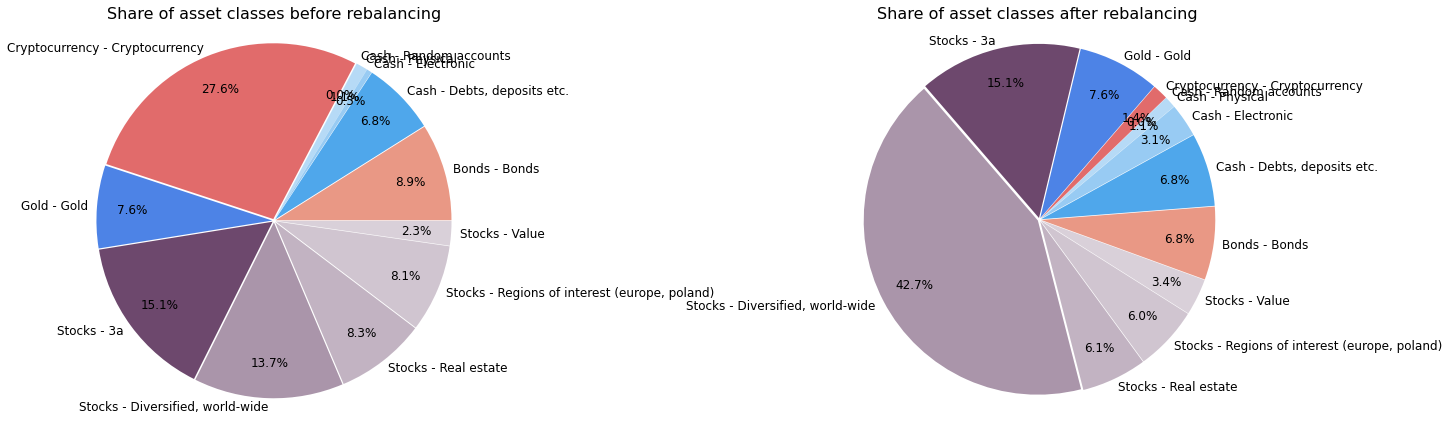

,Category,Subcategory,Asset,Action,Buy / Sell quantity,Value delta in PLN,Start value in PLN,End value in PLN
0,Stocks,"Diversified, world-wide",VANGUARD TOT WORLD STK ETF,Buy,831.0,"81,920.0","36,535.7","118,455.7"
1,Stocks,"Diversified, world-wide",VANGUARD VALUE ETF,Buy,831.0,"103,434.6","46,131.1","149,565.6"
2,Stocks,Value,Broker 8,Buy,"4,858.0","4,858.0","1,820.0","6,678.0"
3,Stocks,Value,Cash PLN,Buy,"2,429.0","2,429.0","2,873.0","5,302.0"
4,Stocks,"Regions of interest (europe, poland)",ISHARES MSCI POLAND ETF,Sell,100.0,"1,915.0","7,097.4","5,182.4"
5,Stocks,"Regions of interest (europe, poland)",UBS ETF SXI REAL ESTATE,Sell,100.0,"3,482.0","14,490.8","11,008.8"
6,Stocks,"Regions of interest (europe, poland)",VANGUARD TOTAL WORLD BOND ET,Sell,97.0,"7,865.7","30,053.6","22,187.8"
7,Stocks,Real estate,ISHARES GOLD TRUST,Sell,100.0,"1,736.0","6,434.0","4,698.0"
8,Stocks,Real estate,VANGUARD GLBL EX-US REAL EST,Sell,100.0,"5,475.0","20,291.4","14,816.4"
9,Stocks,Real estate,ISHARS RES AND MULTI REALES,Sell,100.0,"7,161.0","26,540.1","19,379.1"


In [8]:
# Category and subcategfory to allocate any value left after rebalancing
# due to lacking divisbility of certain assets
leftover_cat = "Cryptocurrency"
leftover_subcat = "Cryptocurrency"

# That is a min value in your default currency from which
# any rebalancing recommendation will be made
min_delta = 0
reb_style = "predefined"

portfolio.rebalance(rebalancing_style=reb_style, leftover_cat=leftover_cat,
                    leftover_subcat=leftover_subcat, min_delta=min_delta)

In [9]:
import Dupa

dupa = Dupa.Dupa()
dupa.dupiej()

dupa blada
dupiej
